In [1]:
import cv2
import matplotlib.pyplot as plt

In [2]:
def plot_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

def insert_boundingboxes(boxes, image, method=None):
    frame = image.copy()
    if boxes is not None:
        for box in boxes:
            if method == 'CNN':
                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            else:
                x, y, w, h = map(int, box)
                cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
            
    return frame

In [3]:
image = cv2.imread('../images/ada.jpg')

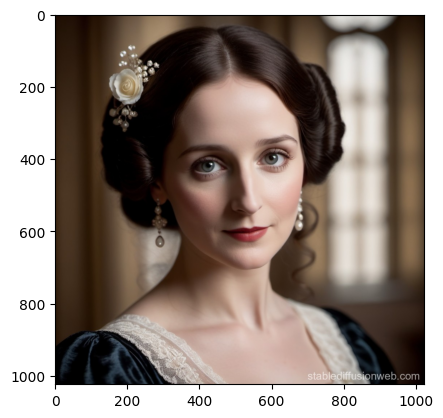

In [4]:
plot_image(image)

## 1. Viola

In [5]:
def viola_jones_detection(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    return faces

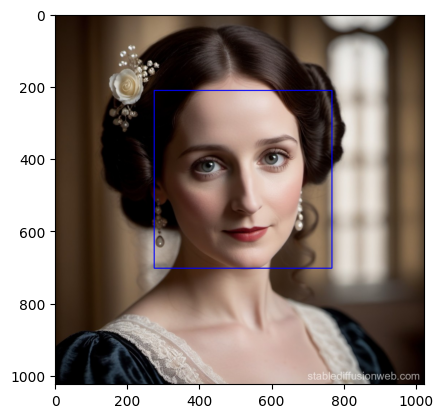

In [6]:
boundingboxes = viola_jones_detection(image)
face_detected = insert_boundingboxes(boundingboxes, image)
plot_image(face_detected)

## 2. HOG+SVM

In [7]:
import dlib
import cv2

In [8]:
def hog_svm_detection(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    detector = dlib.get_frontal_face_detector()
    faces = detector(gray, 1)
    boxes = [[face.left(), face.top(), face.width(), face.height()] for face in faces]
    
    return boxes

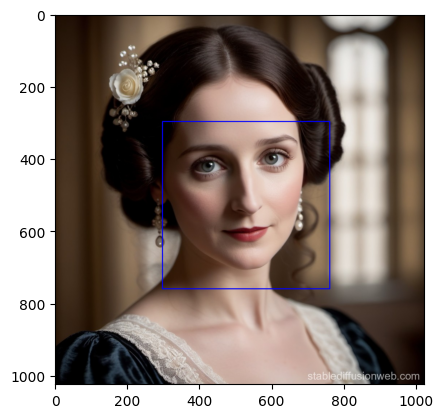

In [9]:
boundingboxes = hog_svm_detection(image)
face_detected = insert_boundingboxes(boundingboxes, image)
plot_image(face_detected)

## 3. Face Net

In [10]:
from facenet_pytorch import MTCNN

In [11]:
def facenet_detection(frame):
    mtcnn = MTCNN(keep_all=True)
    boxes, _ = mtcnn.detect(frame)
    return boxes

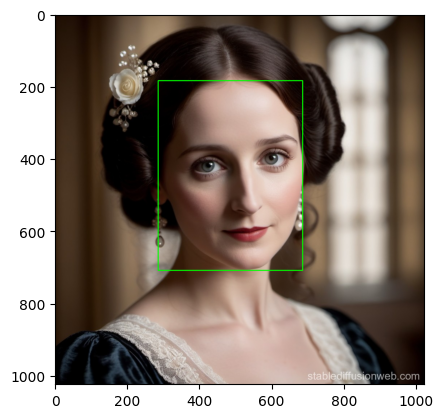

In [12]:
boundingboxes = facenet_detection(image)
face_detected = insert_boundingboxes(boundingboxes, image, method='CNN')
plot_image(face_detected)

## 4. Yolo

In [13]:
from ultralytics import YOLO
import cv2

In [14]:
def yolo_bounding_boxes(image, boxes, confidences, class_ids):
    COCO_CLASSES = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat", "traffic light",
    "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow",
    "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee",
    "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle",
    "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange",
    "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch", "potted plant", "bed",
    "dining table", "toilet", "TV", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven",
    "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
    ]
    frame = image.copy()
    for box, confidence, class_id in zip(boxes, confidences, class_ids):
        # Filtrar apenas a classe 'person' (classe 0 no dataset COCO)
        # if int(class_id) == 0:  # Classe "0" corresponde a "person"
        x_min, y_min, x_max, y_max = map(int, box)
        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv2.putText(frame, f"Conf: {confidence:.2f} Class: {COCO_CLASSES[int(class_id)]}", (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    return frame

def yolo_v8_detection(image):
    model = YOLO('../weights/yolov8n-face.pt')  # Usa o modelo genérico YOLOv8n

    results = model(image)
    frame = image.copy()
    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()  # Coordenadas das caixas
        confidences = result.boxes.conf.cpu().numpy()  # Confiança das detecções
        class_ids = result.boxes.cls.cpu().numpy()  # Classes detectadas

    return boxes, confidences, class_ids


0: 640x640 1 face, 273.9ms
Speed: 12.7ms preprocess, 273.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


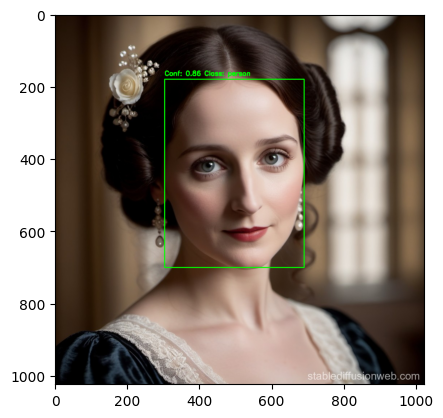

In [15]:
boxes, confidences, class_ids = yolo_v8_detection(image)
face_detected = yolo_bounding_boxes(image, boxes, confidences, class_ids)
plot_image(face_detected)